# 1. The Image Dataset

1.1 
First of all, we're working with a Dataset of pokemons x digimons, and all pokemons are diferents from each other, so as the digimons.

In the beginning of our code we will show how we will treat the images. 

In [ ]:
from google.colab import drive #importing the google drive, so we will be able to use gdrive folders
drive.mount('/content/gdrive')

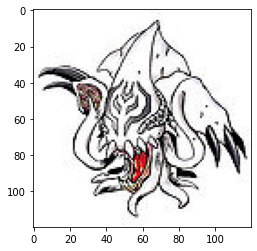

(120, 120, 3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = '/content/drive/MyDrive/Dataset' # we define the path to our image dataset

CATEGORIES = ["Digimon", "Pokemon"]

#this for is to read the image and plot showing the resolution of a RGB image of a Digimon and Pokemon
for category in CATEGORIES:  
    path = os.path.join(DATADIR,category)  
    for img in os.listdir(path):  
        img_path = os.path.join(path,img) 
        img_array = cv2.imread((img_path))  
        img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
        plt.imshow(img_array)  
        plt.show()
        print(img_array.shape) 

        break  
    break 

We will resize all the images so we have a standard to work with.

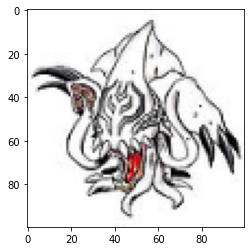

(100, 100, 3)


In [ ]:
IMG_PIXELxPIXEL = 100
IMG_SIZE = [IMG_PIXELxPIXEL,IMG_PIXELxPIXEL]
new_array = cv2.resize(img_array,(IMG_PIXELxPIXEL,IMG_PIXELxPIXEL))
plt.imshow(new_array)
plt.show()
print(new_array.shape)

The same thing we did to the digimon we will do for the pokemons

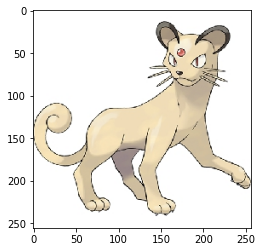

(256, 256, 3)


In [ ]:
DATADIR = '/content/drive/MyDrive/Dataset'

CATEGORIES = ["Pokemon", "Digimon"]

for category in CATEGORIES:  
    path = os.path.join(DATADIR,category)  
    for img in os.listdir(path):  
        img_path = os.path.join(path,img) 
        img_array = cv2.imread((img_path))  
        img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
        plt.imshow(img_array)  
        plt.show()
        print(img_array.shape) 

        break  
    break 

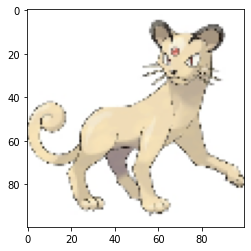

(100, 100, 3)


In [ ]:
IMG_PIXELxPIXEL = 100
IMG_SIZE = [IMG_PIXELxPIXEL,IMG_PIXELxPIXEL]
new_array = cv2.resize(img_array,(IMG_PIXELxPIXEL,IMG_PIXELxPIXEL))
plt.imshow(new_array)
plt.show()
print(new_array.shape)

1.2
We are going to create our training and validation set.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.8,
                                   zoom_range = 0.8,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


In [ ]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Dataset2/Test',
                                                 target_size = (100, 100),
                                                 batch_size = 8,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Dataset2/Train',
                                            target_size = (100, 100),
                                            batch_size = 8,
                                            class_mode = 'categorical')

Found 1910 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [ ]:
print(test_set.class_indices) #We print the classes

{'Digimon': 0, 'Pokemon': 1}


# 2. Importing our VGG16 model.

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

In [ ]:
our_vgg = VGG16(include_top=False,weights='imagenet',input_shape=IMG_SIZE + [3]) #We import the architecture VGG16 with the imagenet weights.

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
#We freeze our model and all the layer so it don't change the Weights
our_vgg.trainable = False

for layer in our_vgg.layers:
  layer.trainable = False

In [ ]:
# our layers - you can add more if you want
x = Flatten()(our_vgg.output)

prediction = Dense(len(CATEGORIES), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=our_vgg.input, outputs=prediction)
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

# 3. Transferlearning and The "W & B"

In [ ]:
#install the wandb in the colab
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


On this part we will creat our project at the wandb web site and set the metrics for our model.

In [ ]:
run = wandb.init(
           project = 'my-CNN-transfer-learning',
           config={  # and include hyperparameters and metadata
                     "learning_rate": 0.00001,
                     "epochs": 50,
                     "batch_size": 8,
                     "loss_function": "binary_crossentropy",
                     "architecture": "VGG16",
                     "dataset": "Pokemon_x_digimon"
                 })

config = wandb.config  # We'll use this to configure our experiment

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

wandb: Currently logged in as: filipeprocopio (use `wandb login --relogin` to force relogin)


In [ ]:
#Training the model with the new data set
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=config.epochs,
  batch_size= config.batch_size,
  callbacks=[WandbCallback()]
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


239/239 [==============================] - 232s 970ms/step - loss: 0.4790 - binary_accuracy: 0.7863 - val_loss: 0.1878 - val_binary_accuracy: 0.9486
Epoch 2/50
239/239 [==============================] - 232s 969ms/step - loss: 0.2451 - binary_accuracy: 0.9115 - val_loss: 0.1598 - val_binary_accuracy: 0.9533
Epoch 3/50
239/239 [==============================] - 232s 970ms/step - loss: 0.2058 - binary_accuracy: 0.9254 - val_loss: 0.1482 - val_binary_accuracy: 0.9579
Epoch 4/50
239/239 [==============================] - 232s 973ms/step - loss: 0.1989 - binary_accuracy: 0.9363 - val_loss: 0.1403 - val_binary_accuracy: 0.9579
Epoch 5/50
239/239 [==============================] - 238s 997ms/step - loss: 0.1803 - binary_accuracy: 0.9291 - val_loss: 0.1566 - val_binary_accuracy: 0.9486
Epoch 6/50
239/239 [==============================] - 237s 993ms/step - loss: 0.1940 - binary_accuracy: 0.9087 - val_loss: 0.1336 - val_binary_accuracy: 0.9626
Epoch 7/50
239/239 [==============================]

As we can see bellow, our model was really good.

In [ ]:
run = wandb.init(
           project = 'my-CNN-transfer-learning',
           config={  # and include hyperparameters and metadata
                     "learning_rate": 0.00001,
                     "epochs": 50,
                     "batch_size": 8,
                     "loss_function": "binary_crossentropy",
                     "architecture": "VGG16",
                     "dataset": "Pokemon_x_digimon"
                 })

config = wandb.config  # We'll use this to configure our experiment

epoch,49
loss,0.11863
binary_accuracy,0.95183
val_loss,0.14182
val_binary_accuracy,0.95794
_runtime,11896
_timestamp,1619213776
_step,49
best_val_loss,0.13187
best_epoch,8


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▂▁▁
binary_accuracy,▁▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇█▇▇█▇▇█▇
val_loss,▆▃▂▂▁▇▄▁▃▂▂▇▁▅▇▂▄▂▂▄▅▇▄▆▆▄▆█▅▃▄▅▂▂▇▂▃▆▄▂
val_binary_accuracy,▅▆▇▇█▁▅▇▆▇▅▂▆▆▄▅▅▆▅▄▅▃▄▄▅▄▅▄▅▅▅▅▇▆▅▅▇▅▅▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


# 4. Finetuning

To improve even more our model we're going to finetune it, so to finetune, we will unfreeze the weights and define a tiny leaning rate so our model can adjust even more to our image data set.

In [ ]:
our_vgg.trainable = True

for layer in our_vgg.layers:
  layer.trainable = True

In [ ]:
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [ ]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=(config.epochs),
  batch_size= (config.batch_size),
  callbacks=[WandbCallback()]
)

As we can see, the results were even better than the VGG16 normal architecture.

Epoch 1/50
239/239 [==============================] - 756s 3s/step - loss: 0.1746 - binary_accuracy: 0.9347 - val_loss: 0.1488 - val_binary_accuracy: 0.9626

Epoch 2/50
239/239 [==============================] - 762s 3s/step - loss: 0.1183 - binary_accuracy: 0.9583 - val_loss: 0.1321 - val_binary_accuracy: 0.9486

Epoch 3/50
239/239 [==============================] - 761s 3s/step - loss: 0.1424 - binary_accuracy: 0.9453 - val_loss: 0.1202 - val_binary_accuracy: 0.9579

Epoch 4/50
239/239 [==============================] - 757s 3s/step - loss: 0.1116 - binary_accuracy: 0.9548 - val_loss: 0.0890 - val_binary_accuracy: 0.9720

Epoch 5/50
239/239 [==============================] - 755s 3s/step - loss: 0.0648 - binary_accuracy: 0.9748 - val_loss: 0.0953 - val_binary_accuracy: 0.9720

Epoch 6/50
239/239 [==============================] - 753s 3s/step - loss: 0.0727 - binary_accuracy: 0.9711 - val_loss: 0.1202 - val_binary_accuracy: 0.9720

Epoch 7/50
239/239 [==============================] - 753s 3s/step - loss: 0.0584 - binary_accuracy: 0.9748 - val_loss: 0.1153 - val_binary_accuracy: 0.9673

Epoch 8/50
239/239 [==============================] - 753s 3s/step - loss: 0.0585 - binary_accuracy: 0.9779 - val_loss: 0.1008 - val_binary_accuracy: 0.9673

Epoch 9/50
239/239 [==============================] - 754s 3s/step - loss: 0.0646 - binary_accuracy: 0.9733 - val_loss: 0.1893 - val_binary_accuracy: 0.9673

Epoch 10/50
239/239 [==============================] - 756s 3s/step - loss: 0.0506 - binary_accuracy: 0.9772 - val_loss: 0.0802 - val_binary_accuracy: 0.9766

Epoch 11/50
239/239 [==============================] - 780s 3s/step - loss: 0.0507 - binary_accuracy: 0.9812 - val_loss: 0.0678 - val_binary_accuracy: 0.9766

Epoch 12/50
239/239 [==============================] - 774s 3s/step - loss: 0.0729 - binary_accuracy: 0.9704 - val_loss: 0.1604 - val_binary_accuracy: 0.9579

Epoch 13/50
239/239 [==============================] - 801s 3s/step - loss: 0.0259 - binary_accuracy: 0.9898 - val_loss: 0.0617 - val_binary_accuracy: 0.9766

Epoch 14/50
239/239 [==============================] - 767s 3s/step - loss: 0.0283 - binary_accuracy: 0.9887 - val_loss: 0.0428 - val_binary_accuracy: 0.9860

Epoch 15/50
239/239 [==============================] - 768s 3s/step - loss: 0.0260 - binary_accuracy: 0.9924 - val_loss: 0.0412 - val_binary_accuracy: 0.9813

Epoch 16/50
239/239 [==============================] - 847s 4s/step - loss: 0.0287 - binary_accuracy: 0.9898 - val_loss: 0.0246 - val_binary_accuracy: 0.9860

Epoch 17/50
239/239 [==============================] - 758s 3s/step - loss: 0.0342 - binary_accuracy: 0.9891 - val_loss: 0.0966 - val_binary_accuracy: 0.9720

Epoch 18/50
239/239 [==============================] - 756s 3s/step - loss: 0.0342 - binary_accuracy: 0.9835 - val_loss: 0.0588 - val_binary_accuracy: 0.9813

Epoch 19/50
239/239 [==============================] - 757s 3s/step - loss: 0.0180 - binary_accuracy: 0.9942 - val_loss: 0.0560 - val_binary_accuracy: 0.9813

Epoch 20/50
239/239 [==============================] - 756s 3s/step - loss: 0.0343 - binary_accuracy: 0.9839 - val_loss: 0.2238 - val_binary_accuracy: 0.9486

Epoch 21/50
239/239 [==============================] - 756s 3s/step - loss: 0.0130 - binary_accuracy: 0.9980 - val_loss: 0.0766 - val_binary_accuracy: 0.9766

Epoch 22/50
239/239 [==============================] - 757s 3s/step - loss: 0.0579 - binary_accuracy: 0.9823 - val_loss: 0.0546 - val_binary_accuracy: 0.9813

Epoch 23/50
239/239 [==============================] - 756s 3s/step - loss: 0.0290 - binary_accuracy: 0.9869 - val_loss: 0.0597 - val_binary_accuracy: 0.9766

Epoch 24/50
239/239 [==============================] - 756s 3s/step - loss: 0.0224 - binary_accuracy: 0.9923 - val_loss: 0.0540 - val_binary_accuracy: 0.9860

Epoch 25/50
239/239 [==============================] - 758s 3s/step - loss: 0.0380 - binary_accuracy: 0.9872 - val_loss: 0.0968 - val_binary_accuracy: 0.9626

Epoch 26/50
239/239 [==============================] - 756s 3s/step - loss: 0.0264 - binary_accuracy: 0.9908 - val_loss: 0.0488 - val_binary_accuracy: 0.9766

Epoch 27/50
239/239 [==============================] - 755s 3s/step - loss: 0.0209 - binary_accuracy: 0.9911 - val_loss: 0.1720 - val_binary_accuracy: 0.9533

Epoch 28/50
239/239 [==============================] - 754s 3s/step - loss: 0.0250 - binary_accuracy: 0.9923 - val_loss: 0.0564 - val_binary_accuracy: 0.9720

Epoch 29/50
239/239 [==============================] - 754s 3s/step - loss: 0.0136 - binary_accuracy: 0.9957 - val_loss: 0.1360 - val_binary_accuracy: 0.9720

Epoch 30/50
239/239 [==============================] - 755s 3s/step - loss: 0.0336 - binary_accuracy: 0.9890 - val_loss: 0.0819 - val_binary_accuracy: 0.9766

Epoch 31/50
239/239 [==============================] - 754s 3s/step - loss: 0.0227 - binary_accuracy: 0.9942 - val_loss: 0.0740 - val_binary_accuracy: 0.9720

Epoch 32/50
239/239 [==============================] - 755s 3s/step - loss: 0.0137 - binary_accuracy: 0.9958 - val_loss: 0.0803 - val_binary_accuracy: 0.9766